In [284]:
import sys, os, importlib

def reload_abs_helper():
    """
    Force reload abs_helper/abs_helper.py and return the ABSHelper class.
    Always pulls the latest version from disk.
    """
    # ensure project root is on sys.path
    sys.path.append(os.path.abspath(".."))

    # import + reload the module
    import abs_helper.abs_helper
    importlib.reload(abs_helper.abs_helper)

    # import the class from the reloaded module
    from abs_helper.abs_helper import ABSHelper, ABSInterface


In [277]:
import os, sys, importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pybaseball
from pybaseball import statcast
import seaborn as sns
import requests
from matplotlib.colors import TwoSlopeNorm

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, GroupKFold, train_test_split
from sklearn.metrics import roc_auc_score, log_loss, make_scorer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from scipy.stats import randint, loguniform, uniform
from sklearn.metrics import f1_score, confusion_matrix, classification_report, brier_score_loss, average_precision_score
import joblib, json

In [288]:
# Add project root (parent of "abs_helper" and "notebooks") to sys.path
sys.path.append(os.path.abspath(".."))
import abs_helper.abs_helper
importlib.reload(abs_helper.abs_helper)
from abs_helper.abs_helper import ABSHelper,ABSInterface


In [272]:
user = ABSInterface(
    "../saved_models/mcm_calib.pkl",
    "../saved_models/wpm_calib.pkl",
    "../saved_dcts/ump_name_dct.json",
    "../saved_dcts/ump_zone_acc.joblib"
)
case = {
    "pitch_loc": "mid_middle",
    "outs_when_up": 2,
    "pitcher_is_rhand": False,
    "pitch_type": "SI",     # any category used in training
    "batter_is_rhand": True,
    "call": "ball",             # actual umpire call
    "ump_id": 427093,                # placeholder umpire ID
    "strikes": 2,
    "balls": 3,
    "inning": 9
    # NOTE: exclude 'incorrect_call_prob' and 'win_prob'
}

print(user.predict_incorrect_call_prob(case))

case = {
    "inning_topbot": 'Bot',
    "base_state": '111',
    "team_bat_score_diff": -1
    # NOTE: exclude 'incorrect_call_prob' and 'win_prob'
}
user.predict_dwe(case)


19.013


{'delta_we': 0.12367, 'challenge': True}

In [119]:
pybaseball.cache.enable()
data = statcast('2025-03-01','2025-09-29')

This is a large query, it may take a moment to complete
Skipping offseason dates


  1%|          | 1/199 [00:00<00:26,  7.52it/s]c:\Users\tyism\AppData\Local\Programs\Python\Python313\Lib\site-packages\pybaseball\datahelpers\postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
c:\Users\tyism\AppData\Local\Programs\Python\Python313\Lib\site-packages\pybaseball\datahelpers\postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
c:\Users\tyism\AppData\Local\Programs\Python\Python313\Lib\site-packages\pybaseball\datahelpers\postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future versi

In [329]:
test_abs = ABSHelper()

In [330]:
test_abs.load_raw_data(data)

In [331]:
# test_abs.preprocess_data()

In [332]:
# temp_df = test_abs.df.copy()

In [333]:
# temp_df.to_csv('../saved_csv/abs_helper_df_2025.csv', index=True)

In [334]:
test_abs.df = pd.read_csv('../saved_csv/abs_helper_df_2025.csv',index_col=0)

In [335]:
# test_abs.save_dct(test_abs.ump_game_dct, '../saved_dcts/ump_game_dct.json')
# test_abs.save_dct(test_abs.ump_name_dct, '../saved_dcts/ump_name_dct.json')
# test_abs.save_series(test_abs.ump_zone_acc, '../saved_dcts/ump_zone_acc.joblib')

In [336]:
test_abs.ump_game_dct = test_abs.load_dct('../saved_dcts/ump_game_dct.json')
test_abs.ump_name_dct = test_abs.load_dct('../saved_dcts/ump_name_dct.json', int_keys=True)
test_abs.ump_zone_acc = test_abs.load_series('../saved_dcts/ump_zone_acc.joblib')

In [337]:
test_abs.prepare_train_test_data_mcm()

In [338]:
# test_abs.mcm = test_abs.train_xgb_clf_model(
#     test_abs.X_train_mcm,
#     test_abs.y_train_mcm,
#     test_abs.cat_cols_mcm,
#     test_abs.num_cols_mcm,
# )

In [339]:
test_abs.mcm = test_abs.load_model('../saved_models/mcm.pkl')

In [340]:
test_abs.evaluate_xgb_clf_model(test_abs.mcm, test_abs.X_test_mcm, test_abs.y_test_mcm)

{'roc_auc': np.float64(0.6630769347912353),
 'log_loss': 0.42843929497093003,
 'f1': 0.1652249134948097,
 'average_precision': np.float64(0.13265267722174384)}

In [341]:
print(classification_report(test_abs.y_test_mcm, test_abs.mcm.predict(test_abs.X_test_mcm)))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     81843
           1       0.16      0.17      0.17      6584

    accuracy                           0.87     88427
   macro avg       0.55      0.55      0.55     88427
weighted avg       0.88      0.87      0.87     88427



In [342]:
# test_abs.calibrate_mcm()

In [343]:
test_abs.mcm_calib = test_abs.load_model('../saved_models/mcm_calib.pkl')

In [344]:
test_abs.mcm_calib.predict_proba(test_abs.X_test_mcm)[:,1].mean()

np.float64(0.07421426727155096)

In [416]:
test_abs.evaluate_xgb_clf_model(test_abs.mcm_calib, test_abs.X_test_mcm, test_abs.y_test_mcm)

{'roc_auc': np.float64(0.6626452754450631),
 'log_loss': 0.2526090471247827,
 'f1': 0.002424977265838133,
 'average_precision': np.float64(0.13263841859619807)}

In [415]:
print(classification_report(test_abs.y_test_mcm, test_abs.mcm_calib.predict(test_abs.X_test_mcm)))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     81843
           1       0.57      0.00      0.00      6584

    accuracy                           0.93     88427
   macro avg       0.75      0.50      0.48     88427
weighted avg       0.90      0.93      0.89     88427



In [ ]:
def get_feature_names_from_column_transformer(ct):
    """Extract feature names from a fitted ColumnTransformer (with OneHotEncoder)."""
    output_features = []
    for name, transformer, cols in ct.transformers_:
        if transformer == "drop":
            continue
        if transformer == "passthrough":
            output_features.extend(cols)
        elif hasattr(transformer, "get_feature_names_out"):
            # OneHotEncoder, StandardScaler, etc.
            try:
                fn = transformer.get_feature_names_out(cols)
            except TypeError:
                fn = transformer.get_feature_names_out()
            output_features.extend(fn)
        else:
            output_features.extend(cols)
    return output_features

def show_top_xgb_features(searchcv, top_n=20):
    # unwrap pipeline
    pipe = searchcv.best_estimator_
    prep = pipe.named_steps["prep"]
    model = pipe.named_steps["clf"]

    # get feature names after prep
    feat_names = get_feature_names_from_column_transformer(prep)

    # get importance from XGB
    booster = model.get_booster()
    score = booster.get_score(importance_type="gain")

    # map booster keys ("f0", "f1", ...) to feature names
    mapped = []
    for k, v in score.items():
        idx = int(k[1:])
        name = feat_names[idx] if idx < len(feat_names) else k
        mapped.append((name, v))

    df = pd.DataFrame(mapped, columns=["feature", "importance"])
    df = df.sort_values("importance", ascending=False).reset_index(drop=True)
    return df.head(top_n)

In [569]:
def shorten(feat, feat_cols):
    for col in feat_cols:
        if col in feat:
            return col

<BarContainer object of 10 artists>

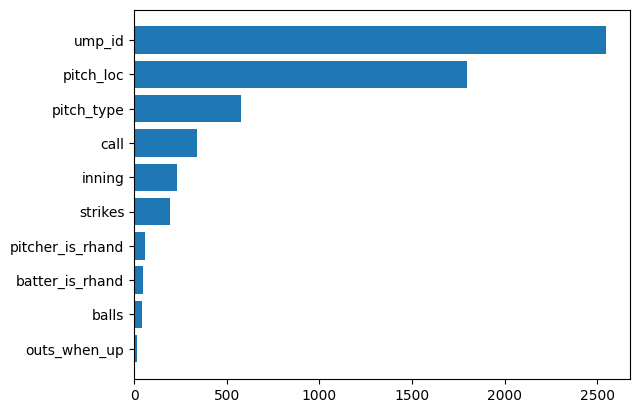

In [578]:
tf = show_top_xgb_features(test_abs.mcm, top_n=None)
tf['feature'] = tf['feature'].apply(shorten, args=(test_abs.feature_cols_mcm,))
tf = tf.groupby('feature')['importance'].sum().sort_values().reset_index()
plt.barh(y=tf['feature'],width=tf['importance'])

<BarContainer object of 7 artists>

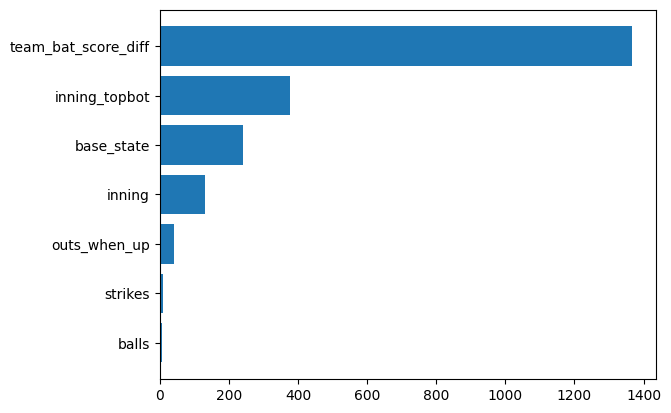

In [588]:
# top_feats = show_top_xgb_features(test_abs.wpm, top_n=20)  # replace with your searchcv object
# plt.barh(y=top_feats['feature'],width=top_feats['importance'])
tf = show_top_xgb_features(test_abs.wpm, top_n=None)
tf['feature'] = tf['feature'].apply(shorten, args=(test_abs.feature_cols_wpm,))
tf = tf.groupby('feature')['importance'].sum().sort_values().reset_index()
plt.barh(y=tf['feature'],width=tf['importance'])

In [345]:
# test_abs.save_model(test_abs.mcm, '../saved_models/mcm.pkl')

In [346]:
# test_abs.save_model(test_abs.mcm_calib, '../saved_models/mcm_calib.pkl')

In [347]:
test_abs.make_wp_df()

,game_date,game_pk,away_team,home_team,inning_topbot,inning,at_bat_number,pitch_number,outs_when_up,base_state,balls,strikes,away_score,home_score,post_away_score,post_home_score,team_bat_score_diff,team_bat_won
0,2025-09-28,776151,DET,BOS,Top,9,74,1,2,110,0,0,3,4,3,4,-1,False
1,2025-09-28,776151,DET,BOS,Top,9,73,4,1,110,0,2,3,4,3,4,-1,False
2,2025-09-28,776151,DET,BOS,Top,9,73,3,1,110,0,2,3,4,3,4,-1,False
3,2025-09-28,776151,DET,BOS,Top,9,73,2,1,110,0,1,3,4,3,4,-1,False
4,2025-09-28,776151,DET,BOS,Top,9,73,1,1,110,0,0,3,4,3,4,-1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710079,2025-03-18,778563,LAD,CHC,Top,1,2,2,1,000,1,0,0,0,0,0,0,True
710080,2025-03-18,778563,LAD,CHC,Top,1,2,1,1,000,0,0,0,0,0,0,0,True
710081,2025-03-18,778563,LAD,CHC,Top,1,1,3,0,000,1,1,0,0,0,0,0,True
710082,2025-03-18,778563,LAD,CHC,Top,1,1,2,0,000,0,1,0,0,0,0,0,True


In [348]:
test_abs.prepare_train_test_data_wpm()

In [349]:
# test_abs.wpm = test_abs.train_xgb_clf_model(
#     test_abs.X_train_wpm,
#     test_abs.y_train_wpm,
#     test_abs.cat_cols_wpm,
#     test_abs.num_cols_wpm
# )

In [350]:
# test_abs.calibrate_wpm()

In [351]:
# test_abs.save_model(test_abs.wpm, '../saved_models/wpm.pkl')

In [352]:
# test_abs.save_model(test_abs.wpm_calib, '../saved_models/wpm_calib.pkl')

In [353]:
test_abs.wpm = test_abs.load_model('../saved_models/wpm.pkl')

In [580]:
test_abs.evaluate_xgb_clf_model(test_abs.wpm, test_abs.X_test_wpm, test_abs.y_test_wpm)

{'roc_auc': np.float64(0.8332096389065295),
 'log_loss': 0.4901865107692478,
 'f1': 0.740494004876443,
 'average_precision': np.float64(0.8440407211932632)}

In [581]:
print(classification_report(test_abs.y_test_wpm, test_abs.wpm.predict(test_abs.X_test_wpm)))

              precision    recall  f1-score   support

       False       0.65      0.90      0.75     85732
        True       0.85      0.53      0.65     90207

    accuracy                           0.71    175939
   macro avg       0.75      0.72      0.70    175939
weighted avg       0.75      0.71      0.70    175939



In [356]:
test_abs.wpm_calib = test_abs.load_model('../saved_models/wpm_calib.pkl')

In [357]:
test_abs.wpm_calib.predict_proba(test_abs.X_test_wpm)[:,1].mean()

np.float64(0.5114931088052251)

In [584]:
test_abs.evaluate_xgb_clf_model(test_abs.wpm_calib, test_abs.X_test_wpm, test_abs.y_test_wpm)

{'roc_auc': np.float64(0.8332096389065295),
 'log_loss': 0.4901865107692478,
 'f1': 0.740494004876443,
 'average_precision': np.float64(0.8440407211932632)}

In [583]:
print(classification_report(test_abs.y_test_wpm, test_abs.wpm_calib.predict(test_abs.X_test_wpm)))

              precision    recall  f1-score   support

       False       0.73      0.74      0.73     85732
        True       0.75      0.74      0.74     90207

    accuracy                           0.74    175939
   macro avg       0.74      0.74      0.74    175939
weighted avg       0.74      0.74      0.74    175939



In [358]:
test_abs.merge_main()

,game_date,game_pk,away_team,home_team,inning_topbot,at_bat_number,pitch_number,base_state,away_score,home_score,...,call,real,correct,incorrect,pitch_loc_vert,pitch_loc_horiz,pitch_loc,events,incorrect_call_prob,win_prob
1,2025-09-28,776151,DET,BOS,Top,73,4,110,3,4,...,strike,strike,True,False,mid,inside,mid_inside,strikeout,0.158861,0.199994
4,2025-09-28,776151,DET,BOS,Top,73,1,110,3,4,...,strike,ball,False,True,mid,inside,mid_inside,NaN,0.136974,0.225510
6,2025-09-28,776151,DET,BOS,Top,72,6,100,3,4,...,ball,ball,True,False,mid,inside,mid_inside,NaN,0.021031,0.178171
9,2025-09-28,776151,DET,BOS,Top,72,3,100,3,4,...,ball,ball,True,False,high,inside,high_inside,NaN,0.028130,0.169936
11,2025-09-28,776151,DET,BOS,Top,72,1,100,3,4,...,strike,strike,True,False,low,away,low_away,NaN,0.103993,0.196429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710073,2025-03-18,778563,LAD,CHC,Bot,4,3,000,0,0,...,ball,ball,True,False,low,away,low_away,NaN,0.083007,0.617753
710074,2025-03-18,778563,LAD,CHC,Bot,4,2,000,0,0,...,ball,ball,True,False,low,inside,low_inside,NaN,0.076884,0.613997
710080,2025-03-18,778563,LAD,CHC,Top,2,1,000,0,0,...,ball,ball,True,False,low,away,low_away,NaN,0.050862,0.428165
710082,2025-03-18,778563,LAD,CHC,Top,1,2,000,0,0,...,ball,ball,True,False,low,inside,low_inside,NaN,0.040947,0.444720


In [609]:
# model improvement over random 7.46% guess

top_probs = test_abs.merged_final.sort_values('incorrect_call_prob',ascending=False)[['incorrect_call_prob','incorrect']].iloc[:int(test_abs.merged_final.shape[0]*.05)]
top_probs_acc = top_probs['incorrect'].mean()
random_acc = test_abs.merged_final['incorrect'].mean()
(top_probs_acc - random_acc) / random_acc

np.float64(1.6687476118427218)

In [614]:
test_abs.merged_final.sample(10).sort_values('incorrect_call_prob')[test_abs.feature_cols_mcm+['incorrect_call_prob']]

,ump_id,pitch_type,pitch_loc,inning,call,outs_when_up,pitcher_is_rhand,balls,strikes,batter_is_rhand,incorrect_call_prob
522636,428442,FS,mid_inside,6,ball,0,True,1,2,False,0.015810
86812,521889,FF,high_inside,8,ball,0,True,1,2,False,0.030270
431137,427129,FC,low_away,8,ball,1,False,2,0,False,0.070353
444410,547380,SI,low_away,6,ball,2,True,0,0,True,0.072409
363375,503077,FF,high_inside,5,ball,0,True,0,1,False,0.079879
106778,676581,FC,high_middle,5,ball,0,True,0,0,False,0.106406
632431,483564,FF,high_away,2,ball,1,True,0,0,False,0.109208
674392,483569,ST,low_inside,7,strike,0,False,0,0,False,0.120099
134960,665297,FF,high_away,7,strike,0,True,1,0,True,0.130289
504914,605670,SI,high_inside,1,strike,2,False,2,0,False,0.130674


In [359]:
test_abs.make_future_states()

In [360]:
test_abs.merge_final(True)

,ump_id,pitch_type,pitch_loc,inning,call,outs_when_up,pitcher_is_rhand,balls,strikes,batter_is_rhand,...,win_prob,win_prob_s,win_prob_o,ump_name,game_pk,events,real,correct,incorrect,win_prob_u
1,483919,FF,mid_inside,9,strike,1,True,0,2,True,...,0.199994,0.161781,0.205938,Mark Ripperger,776151,strikeout,strike,True,False,0.044157
4,483919,SL,mid_inside,9,strike,1,True,0,0,True,...,0.225510,0.212849,0.225510,Mark Ripperger,776151,NaN,ball,False,True,0.012661
6,483919,FF,mid_inside,9,ball,1,True,1,2,True,...,0.178171,0.181252,0.132129,Mark Ripperger,776151,NaN,ball,True,False,0.049123
9,483919,FF,high_inside,9,ball,1,True,0,2,True,...,0.169936,0.178171,0.132129,Mark Ripperger,776151,NaN,ball,True,False,0.046042
11,483919,SI,low_away,9,strike,1,True,0,0,True,...,0.196429,0.187657,0.199994,Mark Ripperger,776151,NaN,strike,True,False,0.012337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710073,427344,FF,low_away,1,ball,0,True,2,0,False,...,0.617753,0.628645,0.613997,Bill Miller,778563,NaN,ball,True,False,0.014648
710074,427344,FF,low_inside,1,ball,0,True,1,0,False,...,0.613997,0.617753,0.608499,Bill Miller,778563,NaN,ball,True,False,0.009255
710080,427344,FS,low_away,1,ball,1,False,0,0,True,...,0.428165,0.436911,0.425183,Bill Miller,778563,NaN,ball,True,False,0.011728
710082,427344,SL,low_inside,1,ball,0,False,0,1,False,...,0.444720,0.446422,0.441527,Bill Miller,778563,NaN,ball,True,False,0.004895


In [620]:
test_abs.add_delta_we_col(test_abs.universal_lambda)
test_abs.merged_final['challenge'].mean()

np.float64(0.022134076696031756)

In [643]:
avg_pitches_per_game = test_abs.raw_df.groupby(['game_pk','inning_topbot'])['game_date'].count().mean()

In [646]:
(test_abs.merged_final['challenge'].mean()) * avg_pitches_per_game

np.float64(3.2339616700874516)

In [363]:
test_abs.universal_lambda+.002806

0.008671236180904523

In [622]:
test_abs.calculate_cost_mean(test_abs.merged_final, test_abs.universal_lambda)

np.float64(1.9993038638934955)

In [634]:
test_abs.raw_df[
    (test_abs.raw_df['game_pk']==776164) & (test_abs.raw_df['inning_topbot']=='Top')
]

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
4453,FF,2025-09-27,97.2,-1.45,6.27,"Keller, Brad",701675,641745,strikeout,swinging_strike,...,1,1.24,0.0,0.0,47.6,-1.336082,17.676305,28.332046,43.010968,16.57051
4454,FF,2025-09-27,94.9,-1.56,6.25,"Keller, Brad",701675,641745,NaN,foul,...,1,1.56,-0.15,0.15,48.7,17.432268,-13.400848,36.642346,30.98734,39.875903
4455,FF,2025-09-27,96.2,-1.55,6.31,"Keller, Brad",701675,641745,NaN,called_strike,...,1,1.23,-0.26,0.26,48.4,<NA>,<NA>,<NA>,<NA>,<NA>
4456,FF,2025-09-27,96.3,-1.49,6.3,"Keller, Brad",701675,641745,NaN,ball,...,1,1.36,-0.06,0.06,46.6,<NA>,<NA>,<NA>,<NA>,<NA>
4457,FF,2025-09-27,95.8,-1.44,6.29,"Keller, Brad",701675,641745,NaN,ball,...,1,1.38,0.26,-0.26,48.3,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4738,FF,2025-09-27,91.9,-1.4,6.11,"Taillon, Jameson",663457,592791,NaN,ball,...,<NA>,1.09,0.77,-0.77,40.0,<NA>,<NA>,<NA>,<NA>,<NA>
4739,CH,2025-09-27,82.9,-1.41,6.21,"Taillon, Jameson",663457,592791,NaN,ball,...,<NA>,2.89,1.2,-1.2,41.7,<NA>,<NA>,<NA>,<NA>,<NA>
4740,FF,2025-09-27,92.0,-1.37,6.14,"Taillon, Jameson",663457,592791,NaN,called_strike,...,<NA>,1.14,0.7,-0.7,46.6,<NA>,<NA>,<NA>,<NA>,<NA>
4741,CU,2025-09-27,78.2,-1.28,6.29,"Taillon, Jameson",663457,592791,NaN,called_strike,...,<NA>,4.39,-0.79,0.79,45.6,<NA>,<NA>,<NA>,<NA>,<NA>


In [2118]:
# test_abs.find_initial_lambda()

np.float64(0.006556761154654402)

In [212]:
# lam_center = 0.008671236180904523
# lam_spread = .00001
# lam_n = 200
# lam_range = np.linspace(lam_center-lam_spread, lam_center+lam_spread, lam_n)
# # # lam_range = np.arange(.004, .0053, .00001)
# # # print(len(lam_range))
# lam_range

In [211]:
# test_abs.find_best_lambda(lam_range)

In [285]:
reload_abs_helper()

In [650]:
def delta_we_top(x):
    return np.percentile(x, 99.9)
def chal_perc(x):
    return (x.mean() * 100).round(2)

In [647]:
from matplotlib.colors import LinearSegmentedColormap

In [649]:
sits = pd.cut(
    test_abs.merged_final['team_bat_score_diff'],
    bins=[-float('inf'), -7.5, -3.5, -0.5, 0.5, 3.5, 7.5, float('inf')],
    labels=[
        "(≤ -8)",
        "(-7 to -4)",
        "(-3 to -1)",
        "(0)",
        "(+1 to +3)",
        "(+4 to +7)",
        "(≥ +8)"
    ]
)


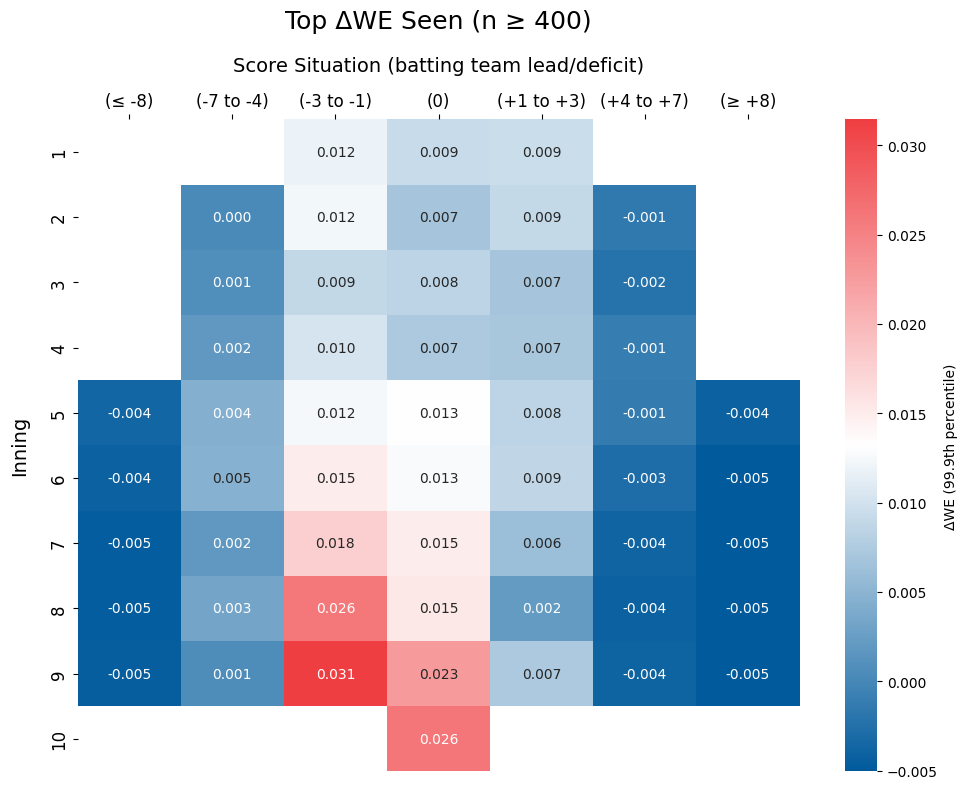

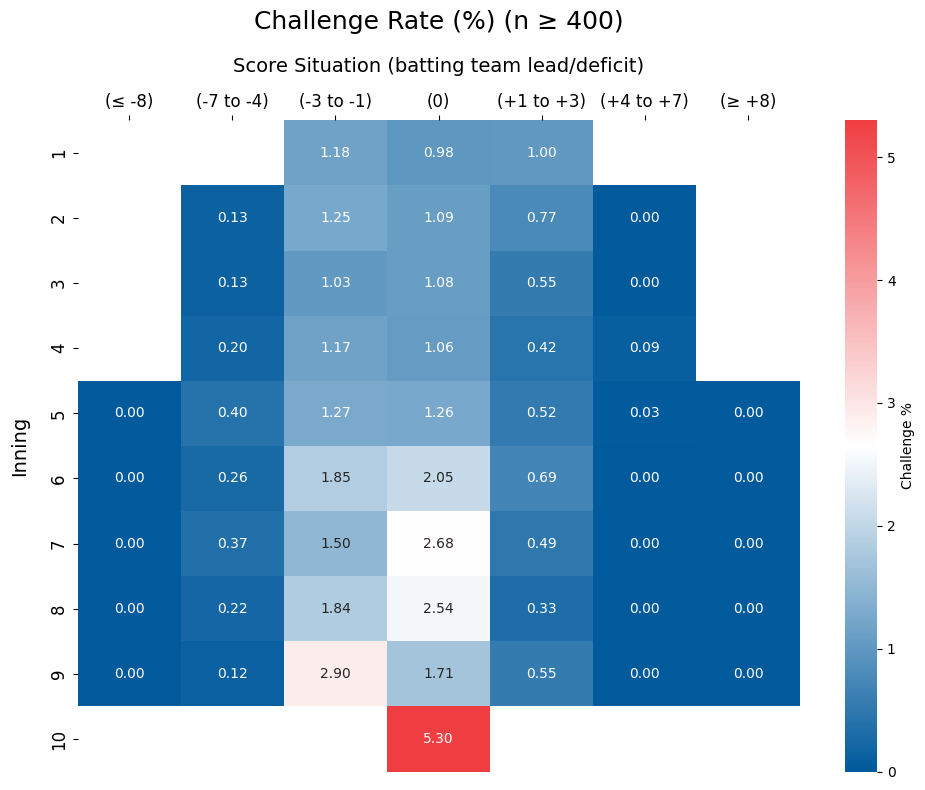

In [655]:
test_merged = test_abs.merged_final[['ump_name', 'inning', 'inning_topbot', 'team_bat_score_diff', 'call', 'challenge', 'delta_we']].copy()
test_merged = test_merged[test_merged['inning']<=10]
test_merged['sits'] = sits
test_merged = test_merged[test_merged['call']=='ball']


dwe_sits = test_merged.pivot_table(
    values='delta_we',
    index='inning',
    columns='sits',
    aggfunc=[delta_we_top,'count'],
    observed=False
)

chal_sits = test_merged.pivot_table(
    values='challenge',
    index='inning',
    columns='sits',
    aggfunc=[chal_perc,'count'],
    observed=False
)

# --- Helper: pick minimum sample size
MIN_COUNT = 400

# Extract tables from your pivots
dwe_heat   = dwe_sits['delta_we_top']
dwe_counts = dwe_sits['count']

chal_heat   = chal_sits['chal_perc']
chal_counts = chal_sits['count']

# Mask out cells below threshold
dwe_mask = dwe_counts < MIN_COUNT
chal_mask = chal_counts < MIN_COUNT

# Compute vmin/vmax using only unmasked values
dwe_valid = dwe_heat.mask(dwe_mask)
chal_valid = chal_heat.mask(chal_mask)

dwe_vmin, dwe_vmax = np.nanmin(dwe_valid.values), np.nanmax(dwe_valid.values)
chal_vmin, chal_vmax = np.nanmin(chal_valid.values), np.nanmax(chal_valid.values)

# --- Plot ΔWE heatmap ---
# Dodgers sequential palette (low → high)
dodger_blue = "#005A9C"
dodger_red  = "#EF3E42"
dodgers_seq = LinearSegmentedColormap.from_list("dodgers_seq", [dodger_blue, "white", dodger_red])

plt.figure(figsize=(10, 8))
sns.heatmap(
    dwe_valid,
    cmap=dodgers_seq,
    vmin=dwe_vmin,
    vmax=dwe_vmax,
    annot=True,
    fmt=".3f",
    cbar_kws={'label': 'ΔWE (99.9th percentile)'}
)
plt.title(f"Top ΔWE Seen (n ≥ {MIN_COUNT})", fontsize=18, pad=20)
plt.xlabel("Score Situation (batting team lead/deficit)", fontsize=14, labelpad=15)
plt.ylabel("Inning", fontsize=14, labelpad=15)
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')
plt.setp(plt.gca().get_xticklabels(), rotation=0, fontsize=12)
plt.setp(plt.gca().get_yticklabels(), fontsize=12)
plt.tight_layout()
plt.show()

# --- Plot Challenge % heatmap ---
plt.figure(figsize=(10, 8))
sns.heatmap(
    chal_valid,
    cmap=dodgers_seq,
    vmin=chal_vmin,
    vmax=chal_vmax,
    annot=True,
    fmt=".2f",
    cbar_kws={'label': 'Challenge %'}
)
plt.title(f"Challenge Rate (%) (n ≥ {MIN_COUNT})", fontsize=18, pad=20)
plt.xlabel("Score Situation (batting team lead/deficit)", fontsize=14, labelpad=15)
plt.ylabel("Inning", fontsize=14, labelpad=15)
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')
plt.setp(plt.gca().get_xticklabels(), rotation=0, fontsize=12)
plt.setp(plt.gca().get_yticklabels(), fontsize=12)
plt.tight_layout()
plt.show()

In [410]:
test_abs.merged_final[
    (test_abs.merged_final['incorrect']) & (test_abs.merged_final['call']=='ball')
].sort_values('delta_we',ascending=False)

,ump_id,pitch_type,pitch_loc,inning,call,outs_when_up,pitcher_is_rhand,balls,strikes,batter_is_rhand,...,win_prob_o,ump_name,game_pk,events,real,correct,incorrect,win_prob_u,delta_we,challenge
237553,482631,SI,high_away,5,ball,1,True,3,2,False,...,0.291845,Mike Estabrook,776934,walk,strike,False,True,0.279218,0.027539,True
176986,623946,FC,high_away,8,ball,0,True,3,2,True,...,0.203311,Malachi Moore,776735,walk,strike,False,True,0.410686,0.024579,True
488600,503502,FF,high_away,10,ball,0,True,3,1,True,...,0.537968,Ryan Blakney,777808,walk,strike,False,True,0.327666,0.023655,True
632312,483564,SI,high_away,6,ball,1,True,3,2,False,...,0.627952,Dan Bellino,778296,walk,strike,False,True,0.240706,0.023428,True
674093,621660,FF,high_middle,7,ball,2,True,3,0,True,...,0.179812,Emil Jimenez,778446,walk,strike,False,True,0.241085,0.019410,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620773,427554,CH,low_inside,2,ball,2,True,1,2,False,...,0.897370,Jim Wolf,778257,NaN,strike,False,True,0.000000,-0.005794,False
708918,482620,CH,low_inside,6,ball,2,True,1,2,False,...,0.876699,Chris Conroy,778546,NaN,strike,False,True,0.000000,-0.005794,False
666213,596809,CH,low_inside,6,ball,2,False,0,2,True,...,0.876699,Ryan Additon,778415,NaN,strike,False,True,0.000000,-0.005796,False
521648,608093,CH,low_inside,8,ball,2,True,1,2,True,...,0.940916,Junior Valentine,777928,NaN,strike,False,True,0.000000,-0.005798,False


In [662]:
egs = test_abs.merged_final.loc[[234865,176986], ['win_prob', 'win_prob_s']]
egs['win_prob_s'] - egs['win_prob']

234865   -0.147213
176986    0.251744
dtype: float64

In [412]:
test_abs.raw_df.loc[[234865], ['game_date','away_team','home_team', 'inning','inning_topbot','home_score','away_score','outs_when_up','balls','strikes','on_1b','on_2b','on_3b','description']]

,game_date,away_team,home_team,inning,inning_topbot,home_score,away_score,outs_when_up,balls,strikes,on_1b,on_2b,on_3b,description
234865,2025-07-30,TOR,BAL,7,Bot,8,9,2,3,2,681297,656811,668939,called_strike


In [414]:
test_abs.raw_df.loc[[176986], ['game_date','away_team','home_team', 'inning','inning_topbot','home_score','away_score','outs_when_up','balls','strikes','on_1b','on_2b','on_3b','description']]

,game_date,away_team,home_team,inning,inning_topbot,home_score,away_score,outs_when_up,balls,strikes,on_1b,on_2b,on_3b,description
176986,2025-08-15,TEX,TOR,8,Bot,3,5,0,3,2,666182,<NA>,676914,ball


In [697]:
ump_zone_acc_pred = test_abs.merged_final.groupby(['ump_id', 'zone'])['incorrect_call_prob'].agg(lambda x: (1-x).mean())